In [2]:
%pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [38]:
import graphviz
from graphviz import Digraph
from IPython.display import Image

In [4]:
import pandas as pd
import datetime as dtm
import numpy as np
from typing import Callable, Union, Any, Optional
from abc import ABC, abstractmethod

import sigtech.framework as sig

env = sig.init()

SigTech environment successfully initialized


## Node Classes

In [39]:
class Node(ABC):
    @abstractmethod
    def evaluate(self, context):
        pass

class DecisionNode(Node):
    def __init__(self, indicator: str, window: int, operator: str, threshold: float, 
                 true_branch: Node, false_branch: Node):
        self.indicator = indicator
        self.window = window
        self.operator = operator
        self.threshold = threshold
        self.true_branch = true_branch
        self.false_branch = false_branch

    def evaluate(self, context):
        # Example evaluation logic
        if self.operator == '>':
            condition_met = context['etf_histories'][self.indicator['etf']].loc[context['midnight_dt']] > self.threshold
        elif self.operator == '<':
            condition_met = context['etf_histories'][self.indicator['etf']].loc[context['midnight_dt']] < self.threshold
        elif self.operator == '>=':
            condition_met = context['etf_histories'][self.indicator['etf']].loc[context['midnight_dt']] >= self.threshold
        elif self.operator == '<=':
            condition_met = context['etf_histories'][self.indicator['etf']].loc[context['midnight_dt']] <= self.threshold
        else:
            raise ValueError(f"Unsupported operator: {self.operator}")
        
        if condition_met:
            return self.true_branch.evaluate(context)
        else:
            return self.false_branch.evaluate(context)

    def get_label(self):
        return f"{self.indicator['name']}({self.indicator['etf']}, {self.window}) {self.operator} {self.threshold}"


class ActionNode(Node):
    def __init__(self, allocations: dict):
        self.allocations = allocations  # e.g., {'SPY': 0.5, 'TLT': 0.5}

    def evaluate(self, context):
        return self.action(context)

    def action(self, context):
        return {
            etf: self.allocations[etf] / context['etf_histories'][etf].asof(context['size_date']) 
            for etf in self.allocations
        }

    def get_label(self):
        allocations_str = ', '.join([f"{etf}: {weight*100:.1f}%" for etf, weight in self.allocations.items()])
        return f"Allocate {allocations_str}"


rendering function

In [40]:
def plot_tree(root_node):
    dot = Digraph(comment='Decision Tree')
    node_counter = [0]  # Mutable counter

    def traverse(node, parent_id=None, edge_label=''):
        node_id = str(node_counter[0])
        node_counter[0] += 1

        if isinstance(node, DecisionNode):
            label = node.get_label()
            dot.node(node_id, label, shape='diamond')
            traverse(node.true_branch, node_id, 'True')
            traverse(node.false_branch, node_id, 'False')
        elif isinstance(node, ActionNode):
            label = node.get_label()
            dot.node(node_id, label, shape='box')
        else:
            dot.node(node_id, 'Unknown', shape='ellipse')

        if parent_id is not None:
            dot.edge(parent_id, node_id, label=edge_label)

    traverse(root_node)
    return dot

## Function Definitions

In [41]:
def get_rsi(data, window):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_gain = up.ewm(com=window - 1, adjust=True).mean()
    avg_loss = down.ewm(com=window - 1, adjust=True).mean()
    rs = avg_gain / avg_loss
    rsi_series = 100 - (100 / (1 + rs))
    return rsi_series

def get_vol(data, window):
    returns = data.pct_change()
    return returns.rolling(window).std()

def get_cum_return(data, window):
    returns = data.pct_change()
    cumulative_returns = (returns + 1).rolling(window).apply(lambda x: x.prod(), raw=True) - 1
    return cumulative_returns.iloc[-1] if len(cumulative_returns) >= window else 0

def allocate_values(default_keys, allocations=None):
    """
    Allocates values to keys in a dictionary. Keys without specific allocations are set to 0.

    :param default_keys: List of keys that should be present in the dictionary.
    :param allocations: Dictionary of keys with their allocated values. If None, all keys will be set to 0.
    :return: Dictionary with allocated values.
    """
    # Initialize the dictionary with 0 for all keys
    result = {key: 0 for key in default_keys}
    
    # If allocations are provided, update the dictionary with those values
    if allocations:
        for key, value in allocations.items():
            if key in result:
                result[key] = value
    
    return result

## Condition Functions

In [42]:
def condition1(context):
    rsi_series = get_rsi(context['etf_histories']['QQQ'], 20)
    midnight_dt = context['midnight_dt']
    if midnight_dt not in rsi_series.index:
        return False
    rsi_value = rsi_series.loc[midnight_dt]
    return rsi_value > 70

def condition2(context):
    vol_series = get_vol(context['etf_histories']['VIXY'], 11)
    midnight_dt = context['midnight_dt']
    if midnight_dt not in vol_series.index:
        return False
    vol_value = vol_series.loc[midnight_dt]
    return vol_value > 0.025

def condition2a(context):
    cumul_bnd = get_cum_return(context['etf_histories']['BND'].loc[:context['midnight_dt']], 60)
    cumul_bil = get_cum_return(context['etf_histories']['BIL'].loc[:context['midnight_dt']], 60)
    return cumul_bnd > cumul_bil

def condition3(context):
    rsi_series = get_rsi(context['etf_histories']['QQQ'], 31)
    midnight_dt = context['midnight_dt']
    if midnight_dt not in rsi_series.index:
        return False
    rsi_value = rsi_series.loc[midnight_dt]
    return rsi_value < 10

## Action Functions

In [43]:
def action1(context, verbose:bool=False):
    weight = context['weight'] * 0.5
    order = {
        context['etfs']['SPY']: weight / context['etf_histories']['SPY'].asof(context['size_date']),
        context['etfs']['TLT']: weight / context['etf_histories']['TLT'].asof(context['size_date']),
    }
    if verbose: print('--ORDER: SPY, TLT')
    return order

def action2a(context, verbose:bool=False):
    weight = context['weight']
    order = {
        context['etfs']['TQQQ']: weight / context['etf_histories']['TQQQ'].asof(context['size_date']),
    }
    if verbose: print('--ORDER: TQQQ')
    return order

def action2b(context, verbose:bool=False):
    weight = context['weight'] * 0.55
    remaining_weight = context['weight'] - weight
    order = {
        context['etfs']['SPY']: weight / context['etf_histories']['SPY'].asof(context['size_date']),
        context['etfs']['SVXY']: remaining_weight * 0.5 / context['etf_histories']['SVXY'].asof(context['size_date']),
        context['etfs']['TLT']: remaining_weight * 0.5 / context['etf_histories']['TLT'].asof(context['size_date']),
    }
    if verbose: print('--ORDER: SPY, SVXY, TLT')
    return order

def action3(context, verbose:bool=False):
    weight = context['weight']
    order = {
        context['etfs']['TQQQ']: weight / context['etf_histories']['TQQQ'].asof(context['size_date']),
    }
    if verbose: print('--ORDER: TQQQ')
    return order

def action4(context, verbose:bool=False):
    weight = context['weight'] * 0.25
    order = {
        context['etfs']['BIL']: weight / context['etf_histories']['BIL'].asof(context['size_date']),
        context['etfs']['SPY']: weight / context['etf_histories']['SPY'].asof(context['size_date']),
        context['etfs']['TLT']: weight / context['etf_histories']['TLT'].asof(context['size_date']),
        context['etfs']['GLD']: weight / context['etf_histories']['GLD'].asof(context['size_date']),
    }
    if verbose: print('--ORDER: BIL, SPY, TLT, GLD')
    return order

## Build the Decision Tree

In [44]:
# Leaf nodes (actions)
action_node1 = ActionNode(allocations={'SPY': 0.5, 'TLT': 0.5})
action_node2a = ActionNode(allocations={'TQQQ': 1.0})
action_node2b = ActionNode(allocations={'SPY': 0.55, 'SVXY': 0.225, 'TLT': 0.225})
action_node3 = ActionNode(allocations={'TQQQ': 1.0})
action_node4 = ActionNode(allocations={'BIL': 0.25, 'SPY': 0.25, 'TLT': 0.25, 'GLD': 0.25})

# Decision nodes
decision_node2a = DecisionNode(
    indicator={'name': 'Cumulative Return', 'etf': 'BND'},
    window=60,
    operator='>',
    threshold=0,  # This will be set dynamically based on actual comparison
    true_branch=action_node2a,
    false_branch=action_node2b
)

decision_node3 = DecisionNode(
    indicator={'name': 'RSI', 'etf': 'QQQ'},
    window=31,
    operator='<',
    threshold=10,
    true_branch=action_node3,
    false_branch=action_node4
)

decision_node2 = DecisionNode(
    indicator={'name': 'Volatility', 'etf': 'VIXY'},
    window=11,
    operator='>',
    threshold=0.025,
    true_branch=decision_node2a,
    false_branch=decision_node3
)

root_node = DecisionNode(
    indicator={'name': 'RSI', 'etf': 'QQQ'},
    window=20,
    operator='>',
    threshold=70,
    true_branch=action_node1,
    false_branch=decision_node2
)

In [45]:
# Initialize the decision tree
class DecisionTree:
    def __init__(self, root):
        self.root = root

    def evaluate(self, context):
        return self.root.evaluate(context)

decision_tree = DecisionTree(root_node)

## basket_creation_method

In [31]:
def basket_creation_method(strategy, dt, positions, **additional_parameters):
    verbose = False
    size_date = pd.Timestamp(strategy.size_date_from_decision_dt(dt))
    midnight_dt = dt.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=None)
    bc_params = additional_parameters
    example_dates = bc_params['example_dates']
    order = {}

    if verbose: print()
    if midnight_dt not in example_dates:
        return {}

    if verbose:
        print(f'DATE: {midnight_dt}')
        print('RSI20 ', get_rsi(etf_histories['QQQ'], 20).loc[midnight_dt])
        print('VOL ', get_vol(etf_histories['VIXY'], 11).loc[midnight_dt])
        print('CUMUL BND', get_cum_return(etf_histories['BND'].loc[:midnight_dt], 60),
              'CUMUL BIL', get_cum_return(etf_histories['BIL'].loc[:midnight_dt], 60),
              'COMPARISON', get_cum_return(etf_histories['BND'].loc[:midnight_dt], 60) > get_cum_return(etf_histories['BIL'].loc[:midnight_dt], 60))
        print('RSI31 ', get_rsi(etf_histories['QQQ'], 31).loc[midnight_dt])

    weight = strategy.initial_cash

    # Build the context for the decision tree
    context = {
        'strategy': strategy,
        'dt': dt,
        'positions': positions,
        'additional_parameters': additional_parameters,
        'size_date': size_date,
        'midnight_dt': midnight_dt,
        'weight': weight,
        'etf_histories': etf_histories,
        'etfs': etfs,
    }

    # Evaluate the decision tree
    order = decision_tree.evaluate(context)

    order = allocate_values([etfs[e] for e in etfs.keys()], order)

    return order

## Data Preparation

In [14]:
etfs = {
    'TLT' : sig.obj.get('TLT US EQUITY'), 
    'TQQQ': sig.obj.get('TQQQ US EQUITY'),
    'SVXY': sig.obj.get('SVXY US EQUITY'),
    'VIXY': sig.obj.get('VIXY US EQUITY'),
    'QQQ' : sig.obj.get('QQQ UP EQUITY'),
    'SPY' : sig.obj.get('SPY UP EQUITY'),
    'BND' : sig.obj.get('BND UP EQUITY'),
    'BIL' : sig.obj.get('BIL UP EQUITY'),
    'GLD' : sig.obj.get('GLD UP EQUITY'),
}

etf_histories = {name: etf.history() for name, etf in etfs.items()}

START_DATE = dtm.date(2024, 6, 2)
END_DATE = dtm.date(2024, 6, 30)
INITIAL_CASH = 1e6

# Example dates from bc_params
example_dates = [
    dtm.datetime(2024, 6, 30, 14, 50, 0),
    dtm.datetime(2024, 6, 27, 0, 0, 0),
    dtm.datetime(2024, 6, 26, 0, 0, 0),
    dtm.datetime(2024, 6, 25, 0, 0, 0),
    dtm.datetime(2024, 6, 24, 0, 0, 0),
    dtm.datetime(2024, 6, 21, 0, 0, 0),
    dtm.datetime(2024, 6, 20, 0, 0, 0),
    dtm.datetime(2024, 6, 18, 0, 0, 0),
    dtm.datetime(2024, 6, 17, 0, 0, 0),
    dtm.datetime(2024, 6, 14, 0, 0, 0),
    dtm.datetime(2024, 6, 13, 0, 0, 0),
    dtm.datetime(2024, 6, 12, 0, 0, 0),
    dtm.datetime(2024, 6, 11, 0, 0, 0),
    dtm.datetime(2024, 6, 10, 0, 0, 0),
    dtm.datetime(2024, 6, 7, 0, 0, 0),
    dtm.datetime(2024, 6, 6, 0, 0, 0),
    dtm.datetime(2024, 6, 5, 0, 0, 0),
    dtm.datetime(2024, 6, 4, 0, 0, 0),
    dtm.datetime(2024, 6, 3, 0, 0, 0)
]

## Initialize sig.DynamicStrategy

In [32]:
strat = sig.DynamicStrategy(
    currency='USD',
    start_date=START_DATE,
    end_date=END_DATE,
    trade_frequency='1BD',
    basket_creation_method=basket_creation_method,
    basket_creation_kwargs={'example_dates': example_dates},
    initial_cash=INITIAL_CASH,
)

strat.build(progress=True)


  0%|                                                   | 0/100 [00:00<?, ?it/s]

In [33]:
strat.plot.performance()

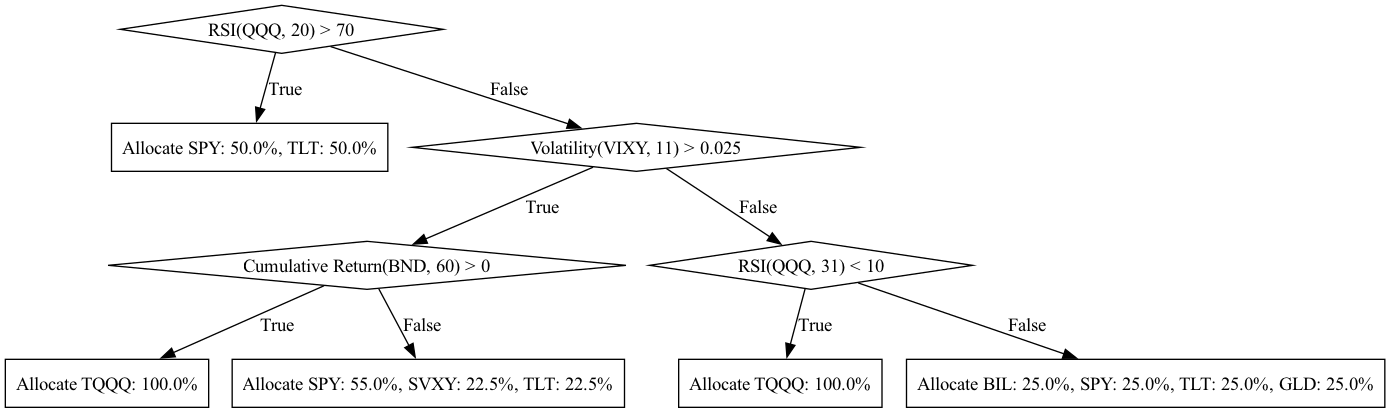

In [46]:
# Plot the tree
dot = plot_tree(root_node)
dot.format = 'png'
dot.render('decision_tree', view=False)
Image(filename='decision_tree.png')